# Machine Learning for Telecom with Naive Bayes

# Introduction

Machine Learning for CallDisconnectReason is a notebook which demonstrates exploration of dataset and CallDisconnectReason classification with Spark ml Naive Bayes Algorithm.


In [1]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from sagemaker import get_execution_role
import sagemaker_pyspark

role = get_execution_role()

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath)\
    .master("local[*]").getOrCreate()

Using S3 Select, enables applications to retrieve only a subset of data from an object by using simple SQL expressions. By using S3 Select to retrieve only the data, you can achieve drastic performance increases – in many cases you can get as much as a 400% improvement.

- _We first read a parquet compressed format of CDR dataset using s3select which has already been processed by Glue._


In [2]:
cdr_start_loc = "<%CDRStartFile%>"
cdr_stop_loc = "<%CDRStopFile%>"
cdr_start_sample_loc = "<%CDRStartSampleFile%>"
cdr_stop_sample_loc = "<%CDRStopSampleFile%>"

df = spark.read.format("s3select").parquet(cdr_stop_sample_loc)
df.createOrReplaceTempView("cdr")

In [3]:
durationDF = spark.sql("SELECT _c13 as CallServiceDuration FROM cdr where _c0 = 'STOP'")
durationDF.count()

22413

# Exploration of Data

- _We see how we can explore and visualize the dataset used for processing. Here we create a bar chart representation of CallServiceDuration from CDR dataset._

In [4]:
import matplotlib.pyplot as plt
durationpd = durationDF.toPandas().astype(int)   

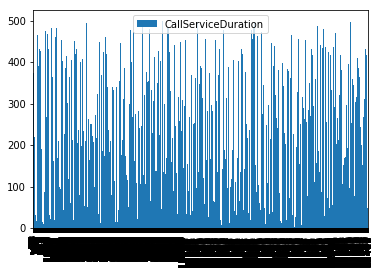

In [5]:
durationpd.plot(kind='bar',stacked=True,width=1)

- _We can represent the data and visualize with a box plot. The box extends from the lower to upper quartile values of the data, with a line at the median._

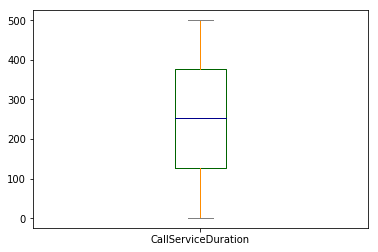

In [6]:
color = dict(boxes='DarkGreen', whiskers='DarkOrange',
           medians='DarkBlue', caps='Gray')

durationpd.plot.box(color=color, sym='r+')

In [7]:
from pyspark.sql.functions import col
durationDF = durationDF.withColumn("CallServiceDuration", col("CallServiceDuration").cast(DoubleType())) 

- _We can represent the data and visualize the data with histograms partitioned in different bins._

(array([48.,  0.,  0., ...,  0.,  0., 44.]),
 array([  1.        ,   1.02226386,   1.04452773, ..., 499.95547227,
        499.97773614, 500.        ]),
 <a list of 22413 Patch objects>)

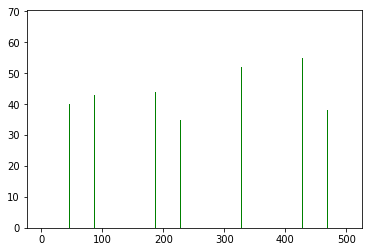

In [8]:
import matplotlib.pyplot as plt

bins, counts = durationDF.select('CallServiceDuration').rdd.flatMap(lambda x: x).histogram(durationDF.count())
plt.hist(bins[:-1], bins=bins, weights=counts,color=['green'])

In [9]:
sqlDF = spark.sql("SELECT _c2 as Accounting_ID, _c19 as Calling_Number,_c20 as Called_Number, _c14 as CallDisconnectReason FROM cdr where _c0 = 'STOP'")
sqlDF.show()

+------------------+--------------+-------------+--------------------+
|     Accounting_ID|Calling_Number|Called_Number|CallDisconnectReason|
+------------------+--------------+-------------+--------------------+
|0x00016E0F31664ABC|    9645000054|   3512000054|                  16|
|0x00016E0F56A018BF|    9645000056|   3512000056|                  16|
|0x00016E0F551FEAD8|    9645000058|   3512000058|                  16|
|0x00016E0F78CAB07B|    9645000060|   3512000060|                  16|
|0x00016E0F32B3EAEA|    9645000062|   3512000062|                  16|
|0x00016E0F50ACD37D|    9645000064|   3512000064|                  16|
|0x00016E0F4C0A02F7|    9645000066|   3512000066|                  16|
| 0x00016E0F543644B|    9645000068|   3512000068|                  16|
|0x00016E0F16D1DDFF|    9645000071|   3512000071|                  16|
|0x00016E0F39C53817|    9645000072|   3512000072|                  16|
| 0x00016E0F9B883FA|    9645000074|   3512000074|                  16|
|0x000

# Featurization 

In [10]:
from pyspark.ml.feature import StringIndexer

accountIndexer = StringIndexer(inputCol="Accounting_ID", outputCol="AccountingIDIndex")
accountIndexer.setHandleInvalid("skip")
tempdf1 = accountIndexer.fit(sqlDF).transform(sqlDF)

callingNumberIndexer = StringIndexer(inputCol="Calling_Number", outputCol="Calling_NumberIndex")
callingNumberIndexer.setHandleInvalid("skip")
tempdf2 = callingNumberIndexer.fit(tempdf1).transform(tempdf1)

calledNumberIndexer = StringIndexer(inputCol="Called_Number", outputCol="Called_NumberIndex")
calledNumberIndexer.setHandleInvalid("skip")
tempdf3 = calledNumberIndexer.fit(tempdf2).transform(tempdf2)

In [11]:
from pyspark.ml.feature import StringIndexer
# Convert target into numerical categories
labelIndexer = StringIndexer(inputCol="CallDisconnectReason", outputCol="label")
labelIndexer.setHandleInvalid("skip")

StringIndexer_41a08fe6cad9682611b9

In [12]:
from pyspark.sql.functions import rand

trainingFraction = 0.75; 
testingFraction = (1-trainingFraction);
seed = 1234;

testData, trainData = tempdf3.randomSplit([trainingFraction, testingFraction], seed=seed);

# CACHE TRAIN AND TEST DATA
trainData.cache()
testData.cache()
trainData.count(),testData.count()

(5541, 16872)

# Analyzing the label distribution

- We analyze the distribution of our target labels using a histogram where 16 represents Normal_Call_Clearing.

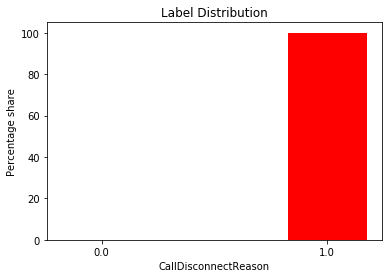

In [13]:
import matplotlib.pyplot as plt

negcount = trainData.filter("CallDisconnectReason != 16").count()
poscount = trainData.filter("CallDisconnectReason == 16").count()

negfrac = 100*float(negcount)/float(negcount+poscount)
posfrac = 100*float(poscount)/float(poscount+negcount)
ind = [0.0,1.0]
frac = [negfrac,posfrac]
width = 0.35

plt.title('Label Distribution')
plt.bar(ind, frac, width, color='r')
plt.xlabel("CallDisconnectReason")
plt.ylabel('Percentage share')
plt.xticks(ind,['0.0','1.0'])
plt.show()

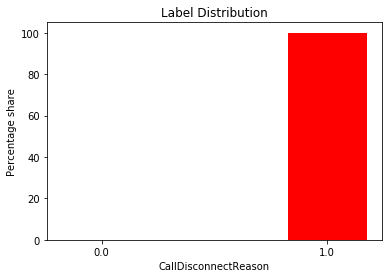

In [14]:
import matplotlib.pyplot as plt

negcount = testData.filter("CallDisconnectReason != 16").count()
poscount = testData.filter("CallDisconnectReason == 16").count()

negfrac = 100*float(negcount)/float(negcount+poscount)
posfrac = 100*float(poscount)/float(poscount+negcount)
ind = [0.0,1.0]
frac = [negfrac,posfrac]
width = 0.35

plt.title('Label Distribution')
plt.bar(ind, frac, width, color='r')
plt.xlabel("CallDisconnectReason")
plt.ylabel('Percentage share')
plt.xticks(ind,['0.0','1.0'])
plt.show()

In [15]:
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols=["AccountingIDIndex","Calling_NumberIndex", "Called_NumberIndex"], outputCol="features")


__Spark ML Naive Bayes__: 
    Naive Bayes is a simple multiclass classification algorithm with the assumption of independence between every pair of features. Naive Bayes can be trained very efficiently. Within a single pass to the training data, it computes the conditional probability distribution of each feature given label, and then it applies Bayes’ theorem to compute the conditional probability distribution of label given an observation and use it for prediction.



- _We use Spark ML Naive Bayes Algorithm and spark Pipeline to train the data set._

In [16]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

# Train a NaiveBayes model
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

# Chain labelIndexer, vecAssembler and NBmodel in a 
pipeline = Pipeline(stages=[labelIndexer,vecAssembler, nb])

# Run stages in pipeline and train model
model = pipeline.fit(trainData)

In [17]:
 # Run inference on the test data and show some results
predictions = model.transform(testData)
predictions.printSchema()
predictions.show()

root
 |-- Accounting_ID: string (nullable = true)
 |-- Calling_Number: string (nullable = true)
 |-- Called_Number: string (nullable = true)
 |-- CallDisconnectReason: string (nullable = true)
 |-- AccountingIDIndex: double (nullable = false)
 |-- Calling_NumberIndex: double (nullable = false)
 |-- Called_NumberIndex: double (nullable = false)
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)

+------------------+--------------+-------------+--------------------+-----------------+-------------------+------------------+-----+-------------------+--------------------+-----------+----------+
|     Accounting_ID|Calling_Number|Called_Number|CallDisconnectReason|AccountingIDIndex|Calling_NumberIndex|Called_NumberIndex|label|           features|       rawPrediction|probability|prediction|
+------------------+--------------+-------------

In [18]:
predictiondf = predictions.select("label", "prediction", "probability")

In [19]:
pddf_pred = predictions.toPandas()

In [20]:
pddf_pred

,Accounting_ID,Calling_Number,Called_Number,CallDisconnectReason,AccountingIDIndex,Calling_NumberIndex,Called_NumberIndex,label,features,rawPrediction,probability,prediction
0,0x00016E0F101981CD,9645000087,3512000087,16,10645.0,68.0,77.0,0.0,"[10645.0, 68.0, 77.0]",[-881.4802138436253],[1.0],0.0
1,0x00016E0F101D715A,9645000086,3512000086,16,4165.0,8.0,9.0,0.0,"[4165.0, 8.0, 9.0]",[-128.82240393748515],[1.0],0.0
2,0x00016E0F1021D8C4,9645000047,3512000047,16,2825.0,42.0,34.0,0.0,"[2825.0, 42.0, 34.0]",[-437.9748062714275],[1.0],0.0
3,0x00016E0F103AD75D,9645000077,3512000077,16,19296.0,34.0,45.0,0.0,"[19296.0, 34.0, 45.0]",[-598.1227115169419],[1.0],0.0
4,0x00016E0F1041A696,9645000001,3512000001,16,6433.0,77.0,80.0,0.0,"[6433.0, 77.0, 80.0]",[-909.9567528077605],[1.0],0.0
5,0x00016E0F104511E6,9645000059,3512000059,16,9768.0,25.0,21.0,0.0,"[9768.0, 25.0, 21.0]",[-335.4676871436684],[1.0],0.0
6,0x00016E0F10553A2,9645000026,3512000026,16,6365.0,31.0,38.0,0.0,"[6365.0, 31.0, 38.0]",[-430.80909137132653],[1.0],0.0
7,0x00016E0F1058F48E,9645000055,3512000055,16,1922.0,6.0,7.0,0.0,"[1922.0, 6.0, 7.0]",[-87.48010828824286],[1.0],0.0
8,0x00016E0F1059CBD6,9645000029,3512000029,16,243.0,54.0,52.0,0.0,"[243.0, 54.0, 52.0]",[-578.5588548611302],[1.0],0.0
9,0x00016E0F105B4BB5,9645000054,3512000054,16,10768.0,22.0,17.0,0.0,"[10768.0, 22.0, 17.0]",[-306.13628682755996],[1.0],0.0


- _We use Scatter plot for visualization and represent the dataset._

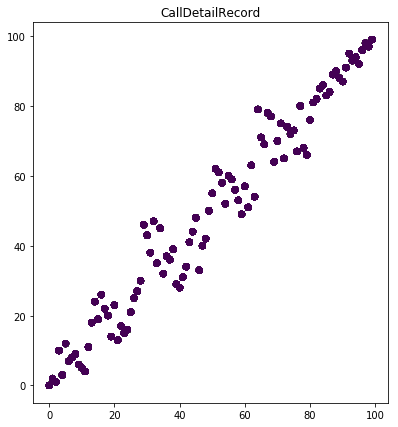

In [21]:
import matplotlib.pyplot as plt
import numpy as np
# Set the size of the plot
plt.figure(figsize=(14,7))
 
# Create a colormap
colormap = np.array(['red', 'lime', 'black'])
 
# Plot CDR
plt.subplot(1, 2, 1)
plt.scatter(pddf_pred.Calling_NumberIndex, pddf_pred.Called_NumberIndex, c=pddf_pred.prediction)
plt.title('CallDetailRecord')
plt.show()

# Evaluation

In [22]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictiondf)
print(accuracy)

1.0


# Confusion Matrix

In [23]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

outdataframe = predictiondf.select("prediction", "label")
pandadf = outdataframe.toPandas()
npmat = pandadf.values
labels = npmat[:,0]
predicted_label = npmat[:,1]

cnf_matrix = confusion_matrix(labels, predicted_label)


In [24]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('label')
    plt.xlabel('Predicted \naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

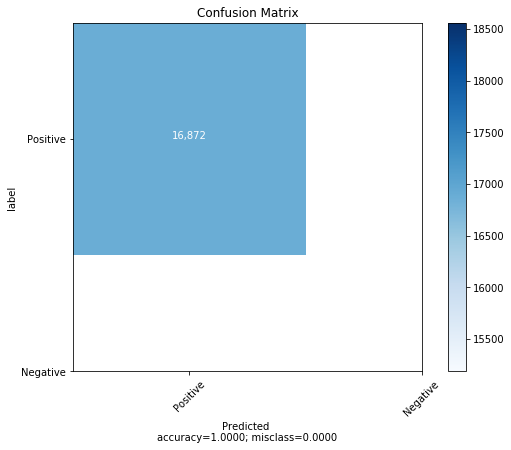

In [25]:
plot_confusion_matrix(cnf_matrix,
                      normalize    = False,
                      target_names = ['Positive', 'Negative'],
                      title        = "Confusion Matrix")

In [26]:
from pyspark.mllib.evaluation import MulticlassMetrics
# Create (prediction, label) pairs
predictionAndLabel = predictiondf.select("prediction", "label").rdd

# Generate confusion matrix
metrics = MulticlassMetrics(predictionAndLabel)
print(metrics.confusionMatrix())

DenseMatrix([[16872.]])



# Cross Validation

In [27]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid and Evaluator for Cross Validation
paramGrid = ParamGridBuilder().addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]).build()
cvEvaluator = MulticlassClassificationEvaluator(metricName="accuracy")

In [28]:
# Run Cross-validation
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=cvEvaluator)
cvModel = cv.fit(trainData)

In [29]:
# Make predictions on testData. cvModel uses the bestModel.
cvPredictions = cvModel.transform(testData)

In [30]:
cvPredictions.select("label", "prediction", "probability").show()

+-----+----------+-----------+
|label|prediction|probability|
+-----+----------+-----------+
|  0.0|       0.0|      [1.0]|
|  0.0|       0.0|      [1.0]|
|  0.0|       0.0|      [1.0]|
|  0.0|       0.0|      [1.0]|
|  0.0|       0.0|      [1.0]|
|  0.0|       0.0|      [1.0]|
|  0.0|       0.0|      [1.0]|
|  0.0|       0.0|      [1.0]|
|  0.0|       0.0|      [1.0]|
|  0.0|       0.0|      [1.0]|
|  0.0|       0.0|      [1.0]|
|  0.0|       0.0|      [1.0]|
|  0.0|       0.0|      [1.0]|
|  0.0|       0.0|      [1.0]|
|  0.0|       0.0|      [1.0]|
|  0.0|       0.0|      [1.0]|
|  0.0|       0.0|      [1.0]|
|  0.0|       0.0|      [1.0]|
|  0.0|       0.0|      [1.0]|
|  0.0|       0.0|      [1.0]|
+-----+----------+-----------+
only showing top 20 rows



In [31]:
# Evaluate bestModel found from Cross Validation
evaluator.evaluate(cvPredictions)

1.0